# SymbolData Test

## Install DuckDB

In [1]:
# 首次使用DuckDB前需先安装扩展
import duckdb
conn = duckdb.connect()
conn.execute("INSTALL sqlite")
conn.close()

In [1]:
import json
import pandas as pd
import re
from asteval import Interpreter
import dataworks as dw

In [19]:
# 重新加载salary计算模块
import importlib
# importlib.reload(variety)
importlib.reload(dw)

<module 'dataworks' from 'e:\\Document\\Project\\futures_nexus\\dataworks.py'>

In [3]:
dws = dw.DataWorksDD()

## 读取配置信息

In [2]:
common_json = 'setting/common.json'
variety_json = 'setting/variety.json'
symbol_id = "RB"

with open(common_json, encoding='utf-8') as common_file: 
    symbol_dataindex_setting = json.load(common_file)['DataIndex']
with open(variety_json, encoding='utf-8') as variety_file:
    variety_setting = json.load(variety_file)[symbol_id]     
variety_setting['DataIndex'] = {**symbol_dataindex_setting, **variety_setting['DataIndex']} if 'DataIndex' in variety_setting else symbol_dataindex_setting
symbol_setting = variety_setting


## Pandas版本merge_data()

In [17]:
# pandas版本load_choice_file_by_polars
def load_choice_file(file_path):
    """读取choice数据终端导出的数据文件.
        Choiced导出文件格式对应的处理规则. 
        - 原文件第一行为“宏观数据“或类似内容,但read_excel方法未加载该行内容
        - 数据的第一行作为指标标题
        - 第一列作为日期
        - 前六行和最后一行都不是数据内容
        - 剔除“日期”字段为空的行和其他非数据内容（标识数据来源的文字内容）
        
        Choice文件导出注意事项:
        - 导出字段选择:指标名称、频率、单位、来源
        - 日期排序:降序
        - 图形设置:不导出图形
        - 勾选“使用函数方式导出”
    Args:
        file_path (str): Choice导出文件(.xlsx)的绝对路径

    Returns:
        dataframe: 将Choice导出文件内容加载到dataframe,并返回
    """
    if file_path=='':
        return None
    df = pd.read_excel(file_path)
    df.columns = df.iloc[0]
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)
    df = df[6:]
    df.reset_index(drop=True, inplace=True)
    df.dropna(axis=0, subset=['date'], inplace=True)
    df = df[df['date'] != '数据来源：东方财富Choice数据']
    df['date'] = pd.to_datetime(df['date'])
    return df

In [18]:
# pandas版本merge_data
def extract_variables(format_str):
    """从格式字符串中提取变量名"""
    # 正则表达式模式，匹配非空字符（即变量）
    variable_pattern = r'\w[\w:()%]*'
    # 使用正则表达式查找所有匹配的变量名
    variables = re.findall(variable_pattern, format_str)
    return variables  # 直接返回找到的变量名列表，无需额外处理

column_dict= {}
data_frames = []
data_index = symbol_setting['DataIndex']

# dws = gs.dataworks
dws = dw.DataWorks()
for key, value_items in data_index.items():
    # 按照配置文件中的DataFrame键值，将同类内容合并到同一张表中
    df_name = value_items['DataFrame']            
    fields = value_items['Field']
    variables_list = extract_variables(fields)
    if df_name in locals():        
        # 键值是独立字段的，列名修改为key
        if len(variables_list)==1:
            locals()[df_name].rename(columns={variables_list[0]:key}, inplace=True)
    else:
        # 未加载的数据，整表读取到df_name中
        data_source = value_items['Source']
        if data_source=='Choice':
            locals()[df_name] = load_choice_file(value_items['Path'])
        elif data_source=='SQLite':
            locals()[df_name] = dws.get_data_by_symbol(value_items['Path'], symbol_id, '*')
            locals()[df_name]['date'] = pd.to_datetime(locals()[df_name]['date'])
        else:
            continue
        column_dict[df_name] = ['date']
    df = locals()[df_name]            
    if len(variables_list)==1:
        # Field是独立字段的，列名修改为key
        df.rename(columns={variables_list[0]:key}, inplace=True)
        column_dict[df_name].append(key)
    else:                
        # Field是公式表达的，进行解析计算
        aeval = Interpreter()       
        for var in variables_list:                    
            safe_var = re.sub(r'[0-9:]', '', var)
            df.rename(columns={var:safe_var}, inplace=True)                                     
            aeval.symtable[safe_var] = df[safe_var]
        safe_fields = re.sub(r'[0-9:]', '', fields)
        df[key] = aeval.eval(safe_fields)
        column_dict[df_name].append(key)
    # 根据配置中指定的填充方式填充缺失值
    if 'FillNa' in value_items:
        fill_na = value_items['FillNa']
        print(f"symbol: {symbol_id}, key: {key}")
        if fill_na=='Forward':
            df[key] = df[key].ffill()
        elif fill_na=='Backward':
            df[key] = df[key].bfill()
        # elif fill_na=='Interpolate':

symbol: RB, key: 库存
symbol: RB, key: 需求生产比
symbol: RB, key: 开工率
symbol: RB, key: 产能利用率


C:\Users\FUDIAN\AppData\Local\Temp\ipykernel_26784\1882601751.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[key] = df[key].ffill()
C:\Users\FUDIAN\AppData\Local\Temp\ipykernel_26784\1882601751.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[key] = df[key].ffill()


## Polars版本merge_data()

In [11]:
# polars版本load_choice_file
import polars as pl
def load_choice_file_by_polars(file_path):
    """读取choice数据终端导出的数据文件.
        Choiced导出文件格式对应的处理规则. 
        - 原文件第一行为“宏观数据“或类似内容,但read_excel方法未加载该行内容
        - 数据的第一行作为指标标题
        - 第一列作为日期
        - 前六行和最后一行都不是数据内容
        - 剔除“日期”字段为空的行和其他非数据内容（标识数据来源的文字内容）
        
        Choice文件导出注意事项:
        - 导出字段选择:指标名称、频率、单位、来源
        - 日期排序:降序
        - 图形设置:不导出图形
        - 勾选“使用函数方式导出”
    Args:
        file_path (str): Choice导出文件(.xlsx)的绝对路径

    Returns:
        dataframe: 将Choice导出文件内容加载到dataframe,并返回
    """
    if file_path == '':
        return None
    df = pl.read_excel(file_path)
    # 设置列名为文件的第二行（索引1），然后去除前7行和最后1行
    df.columns = list(df.row(0))
    # 剔除已用作列名的前7行
    df = df.slice(6, df.height - 7)
    # 剔除“日期”字段为空的行和其他非数据内容
    df = df.filter((pl.col(df.columns[0]).is_not_null()) & (pl.col(df.columns[0]) != '数据来源：东方财富Choice数据'))        
    # 先重命名第一列，然后转换其类型
    df = df.rename({df.columns[0]: "date"})  # 重命名第一列为 'date'
    df = df.with_columns(
        # pl.col("date").str.strptime(pl.Datetime, "%Y-%m-%d").alias("date"),
        pl.col("date").str.strptime(pl.Datetime, "%Y-%m-%d", strict=False).cast(pl.Datetime("us"))
    )  # 转换日期格式
    df = df.with_columns(
        [pl.col(name).cast(pl.Float64) for name in df.columns if name != "date"]
    )        
    return df

In [7]:
# polars版本merge_data()
import polars as pl
from collections import OrderedDict
import time

def _extract_variables(format_str):
    """从格式字符串中提取变量名"""
    # 正则表达式模式，匹配非空字符（即变量）
    variable_pattern = r'\w[\w:()%]*'
    # 使用正则表达式查找所有匹配的变量名
    variables = re.findall(variable_pattern, format_str)
    return variables  # 直接返回找到的变量名列表，无需额外处理

start_time = time.perf_counter()

column_dict= {}
data_frames = {}
data_index = symbol_setting['DataIndex']
symbol_data = None
dws = dw.DataWorksDD()
for key, value_items in data_index.items():
    df_name = value_items['DataFrame']
    fields = value_items['Field']
    variables_list = _extract_variables(fields)
    if df_name in data_frames:        
        df = data_frames[df_name]
        # 键值是独立字段的，列名修改为key
        # if len(variables_list)==1:
        #     df = df.rename({variables_list[0]:key})        
    else:
        data_source = value_items['Source']
        if data_source == 'Choice':
            df = load_choice_file_by_polars(value_items['Path'])
            # data_frames[df_name] = df
        elif data_source == 'SQLite':
            # Suppose we have a method to read from SQLite
            df = dws.get_data_by_symbol(value_items['Path'], symbol_id, '*')
            # df = pl.from_pandas(df)
            # data_frames[df_name] = df
            # df = df.with_columns(
            #     pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date"),
            # )                   
        else:
            continue
        column_dict[df_name] = ['date']
    
    if len(variables_list) == 1:
        df = df.rename({variables_list[0]: key})
        column_dict[df_name].append(key)
    else:
        aeval = Interpreter()
        for var in variables_list:
            safe_var = re.sub(r'[0-9:]', '', var)
            df = df.rename({var:safe_var})       
            aeval.symtable[safe_var] = df.get_column(safe_var)
        safe_fields = re.sub(r'[0-9:]', '', fields)
        df = df.with_columns(pl.lit(aeval.eval(safe_fields)).alias(key))
        column_dict[df_name].append(key)

    if 'FillNa' in value_items:
        fill_na = value_items['FillNa']
        if fill_na == 'Forward':
            df.fill_null(strategy="forward")
        elif fill_na == 'Backward':
            df.fill_null(strategy="backward")
    data_frames[df_name] = df

for df_key in column_dict:    
    data_frames[df_key] = data_frames[df_key][column_dict[df_key]]
    # df = df[column_dict[df_key]]
    # data_frames[df_name] = df   
    # data_frames[df_key] = data_frames[df_key].with_columns(
    #     pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
    # )    
    # print(df_key, column_dict[df_key]) 
    # if symbol_data is None:
    #     symbol_data = data_frames[df_key]
    # else:        
    #     symbol_data = symbol_data.join(data_frames[df_key], on='date', how='outer')

# Concatenate all dataframes into a single dataframe
all_dfs = pl.concat(data_frames.values(), how='align')

# # Dynamically create the aggregation list
# # Use set to remove duplicate column names and avoid 'date'
# # columns_to_aggregate = list(set(all_dfs.columns) - {'date'})
# columns_to_aggregate = list(OrderedDict.fromkeys([col for df in data_frames.values() for col in df.columns if col != 'date']))

# # Build the aggregation expressions
# aggregations = [pl.col(col).first().alias(col) for col in columns_to_aggregate]

# # Group by 'date' and aggregate using dynamically built aggregation list
# symbol_data = all_dfs.group_by("date", maintain_order=True).agg(aggregations)

# symbol_data = symbol_data.sort('date')

trade_dates = dws.get_trade_date()
dws.close()
# valid_dates_mask = self.symbol_data['date'].isin(trade_date)
# self.symbol_data.drop(self.symbol_data.index[~valid_dates_mask], inplace=True)        
symbol_data = all_dfs.filter(pl.col('date').is_in(trade_dates))

merge_time = time.perf_counter()- start_time
print(f'Merge time: {merge_time}')

Merge time: 1.842039900016971


In [ ]:
data_frames.values()

In [5]:
from functools import reduce
for df_key in column_dict:
    df = locals()[df_key]
    df = df[column_dict[df_key]]
    data_frames.append(df)
symbol_data = reduce(lambda left,right: pd.merge(left,right,on='date', how='outer'), data_frames)
# if "利润" in self.symbol_setting:
#     for key, value in enumerate(self.symbol_setting['利润'].items()):
#         variables_list = extract_variables(value)
#         aeval = Interpreter()       
#         for var in variables_list:                                              
#             aeval.symtable[var] = df[var]
#         self.symbol_data[key] = aeval.eval(value)

symbol_data.sort_values(by='date', ascending=True, inplace=True)
columns_to_check = symbol_data.columns[1:]
symbol_data.dropna(subset=columns_to_check, how='all', inplace=True)        

In [34]:
import akshare as ak
trade_date = ak.tool_trade_date_hist_sina()['trade_date']
trade_date = pd.to_datetime(trade_date)


In [35]:
date_column = 'date'
# 筛选出 date 在 trade_date 中的行
valid_dates_mask = symbol_data[date_column].isin(trade_date)
# 删除不属于交易日的行
new_symbol_data2 = symbol_data.loc[valid_dates_mask]

# 或者，如果您希望直接在原数据框上进行修改（inplace=True）
# symbol_data.drop(symbol_data.index[~valid_dates_mask], inplace=True)

In [ ]:
from datetime import datetime, timedelta
start_date = symbol_data['date'].iloc[0]
end_date = symbol_data['date'].iloc[-1]
interval = timedelta(days=1)  
all_date = [start_date + i * interval for i in range((end_date - start_date).days + 1)]

not_trade_date = sorted(set(all_date) - set(trade_date))

In [21]:
# 重新加载salary计算模块
import importlib
importlib.reload(variety)
importlib.reload(dw)

<module 'dataworks' from 'e:\\Document\\Project\\futures_nexus\\dataworks.py'>

In [22]:
import variety
from variety import *
import time
import dataworks as dw
# dws = dw.DataWorksDD()

In [64]:
file_path = 'black_metals/data/螺纹钢经济数据.xlsx'
rb = SymbolData('RB')
start_time = time.perf_counter()
df = rb.load_choice_file(file_path)
run_time = time.perf_counter()- start_time
print(f'Run time: {run_time}')
start_time = time.perf_counter()
df = rb.load_choice_file_by_polars(file_path)
run_time = time.perf_counter()- start_time
print(f'Run time: {run_time}')

Run time: 1.1606265999998868
Run time: 0.9802676999997857


In [42]:

rb = SymbolData('RB')
start_time = time.perf_counter()
rb.merge_data()
merge_time = time.perf_counter()- start_time
print(f'Merge time: {merge_time}')

e:\Document\Project\futures_nexus\variety.py:248: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[key] = df[key].ffill()
e:\Document\Project\futures_nexus\variety.py:248: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[key] = df[key].ffill()


Merge time: 1.866003200004343


In [41]:
importlib.reload(symbol)
import symbol
rb = symbol.Variety('RB')
start_time = time.perf_counter()
rb.load_data()
df = rb.get_data('主力合约收盘价')
merge_time = time.perf_counter()- start_time
print(f'Merge time: {merge_time}')
print(df)

Merge time: 1.4271325999870896
           date  主力合约收盘价
0    2011-01-04   4822.0
1    2011-01-05   4793.0
2    2011-01-06   4809.0
3    2011-01-07   4793.0
4    2011-01-10   4834.0
...         ...      ...
3228 2024-04-24   3681.0
3229 2024-04-25   3669.0
3230 2024-04-26   3685.0
3231 2024-04-29   3675.0
3232 2024-04-30   3656.0

[3233 rows x 2 columns]


In [ ]:
start_time = time.perf_counter()
rb.merge_data_by_polars()
merge_time = time.perf_counter()- start_time
print(f'Merge time(Polars): {merge_time}')

In [11]:
field_list = rb.get_data_fields()

In [ ]:
data_rank = rb.calculate_data_rank('主力合约',field_list,6)

In [ ]:
signals = rb.get_signals(field_list)

In [1]:
import dash_mantine_components as dmc
from dash import Dash, html, Input, Output, State

layout = html.Div([
    dmc.Stack(
        [
            dmc.Button("Open", id="open-modal"),
            dmc.Button("Close", id="close-modal"),
        ],
        spacing="md",
    )
])

## 并行计算测试

### 使用Numba的并行功能

In [33]:
import numpy as np
import time
from numba import jit, prange

# 定义一个计算大数组元素10次方的函数，使用Numba并行
@jit(nopython=True, parallel=True)
def compute_powers(numbers, power=10):
    result = np.zeros_like(numbers)
    for i in prange(len(numbers)):
        result[i] = numbers[i] ** power
    return result

# 创建一个大数组
size = 100000000
numbers = np.random.rand(size)

start_time = time.time()
powered_numbers = compute_powers(numbers)
end_time = time.time()

print(f"Computation of {size} elements to the power of 10 completed.")
print(f"Execution time with parallel Numba: {end_time - start_time:.6f} seconds")

Computation of 100000000 elements to the power of 10 completed.
Execution time with parallel Numba: 0.417245 seconds


In [27]:
def compute_powers(numbers, power=10):
    result = np.zeros_like(numbers)
    for i in prange(len(numbers)):
        result[i] = numbers[i] ** power
    return result

# 创建一个大数组
size = 100000000
numbers = np.random.rand(size)

start_time = time.time()
powered_numbers = compute_powers(numbers)
end_time = time.time()

print(f"Computation of {size} elements to the power of 10 completed.")
print(f"Execution time with parallel Numba: {end_time - start_time:.6f} seconds")

Computation of 100000000 elements to the power of 10 completed.
Execution time with parallel Numba: 12.351819 seconds


### 使用Polars并行计算

In [4]:
import polars as pl

# 创建一个简单的 DataFrame
data = {
    "name": ["Alice", "Bob", "Charlie"],
    "age": [25, 26, 27],
    "city": ["New York", "Los Angeles", "Chicago"]
}

df = pl.DataFrame(data)

# 打印 DataFrame
print("Initial DataFrame:")
print(df)

# 增加一列，表示年龄加十
df = df.with_columns(
    (df["age"] + 10).alias("age_plus_ten")
)

# 打印修改后的 DataFrame
print("\nDataFrame after adding 'age_plus_ten':")
print(df)

# 过滤出年龄大于 30 的行
filtered_df = df.filter(df["age_plus_ten"] > 30)

# 打印过滤后的 DataFrame
print("\nFiltered DataFrame (age_plus_ten > 30):")
print(filtered_df)

# 对城市进行分组并计算每个城市的平均年龄
grouped_df = df.group_by("city").agg(
    pl.col("age").mean().alias("average_age")
)

# 打印分组后的结果
print("\nGrouped DataFrame by 'city' with average age:")
print(grouped_df)


Initial DataFrame:
shape: (3, 3)
┌─────────┬─────┬─────────────┐
│ name    ┆ age ┆ city        │
│ ---     ┆ --- ┆ ---         │
│ str     ┆ i64 ┆ str         │
╞═════════╪═════╪═════════════╡
│ Alice   ┆ 25  ┆ New York    │
│ Bob     ┆ 26  ┆ Los Angeles │
│ Charlie ┆ 27  ┆ Chicago     │
└─────────┴─────┴─────────────┘

DataFrame after adding 'age_plus_ten':
shape: (3, 4)
┌─────────┬─────┬─────────────┬──────────────┐
│ name    ┆ age ┆ city        ┆ age_plus_ten │
│ ---     ┆ --- ┆ ---         ┆ ---          │
│ str     ┆ i64 ┆ str         ┆ i64          │
╞═════════╪═════╪═════════════╪══════════════╡
│ Alice   ┆ 25  ┆ New York    ┆ 35           │
│ Bob     ┆ 26  ┆ Los Angeles ┆ 36           │
│ Charlie ┆ 27  ┆ Chicago     ┆ 37           │
└─────────┴─────┴─────────────┴──────────────┘

Filtered DataFrame (age_plus_ten > 30):
shape: (3, 4)
┌─────────┬─────┬─────────────┬──────────────┐
│ name    ┆ age ┆ city        ┆ age_plus_ten │
│ ---     ┆ --- ┆ ---         ┆ ---          │
│ str 

## 季节性分析

### 趋势-周期-残差分析
- 趋势部分的图表展示了时间序列数据中的长期变化趋势，消除了季节性波动和随机噪声的影响。
- 节性部分的图表显示了数据的周期性波动模式，这种模式在每个周期内重复出现。
- 残差部分包括了数据中除去趋势和季节性之后的剩余波动，通常认为这部分是随机噪声。

如果残差部分相对较小且随机，说明季节性和趋势的分解较为成功，模型有效捕捉了数据的主要特征。反之，则可能需要考虑模型的调整或寻找其他影响因素（异常的残差波动可能暗示重大的市场事件或未被模型捕捉的信息）。

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

# 生成示例数据
np.random.seed(0)
dates = pd.date_range(start='2010-01-01', periods=120, freq='ME')
data = pd.Series(100 + 0.5 * np.arange(120) + 10 * np.sin(2 * np.pi * np.arange(120) / 12) + np.random.normal(size=120), index=dates)

# 应用季节性分解
result = seasonal_decompose(data, model='additive', period=12)

# 创建子图
fig = make_subplots(rows=2, cols=1, subplot_titles=('Original and Trend Data', 'Seasonal and Residual Data'))

# 添加原始数据图表和趋势数据到第一个子图
fig.add_trace(go.Scatter(x=dates, y=data, mode='lines', name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=dates, y=result.trend, mode='lines', name='Trend'), row=1, col=1)

# 添加季节性数据到第二个子图
fig.add_trace(go.Scatter(x=dates, y=result.seasonal, mode='lines', name='Seasonal'), row=2, col=1)

# 添加残差数据到第二个子图，使用散点图表示
fig.add_trace(go.Scatter(x=dates, y=result.resid, mode='markers', name='Residual'), row=2, col=1)

# 更新布局设置
fig.update_layout(height=800, width=700, title_text="Seasonal Decomposition of Time Series", showlegend=True)
fig.update_xaxes(title_text="Date", row=2, col=1)  # Add x-axis label to the last chart for clarity

# 显示图表
fig.show()


### 周期性分析

ACF（自相关函数）图表解读
ACF图表显示了时间序列与其自身过去值的相关性。图表的Y轴表示自相关系数，X轴表示滞后数（lag），即时间间隔数。

- 横轴（Lag）：表示时间延迟的数量。例如，Lag 1表示一个时间单位的延迟。
- 纵轴（Correlation）：表示给定滞后的自相关系数，范围从-1到+1。接近+1或-1表示强相关，接近0表示几乎无相关。
如何解读
- 缓慢下降的ACF：如果ACF值缓慢下降，这通常表明数据中存在较长时间的影响，可能是一个随机漫步过程。
- 截尾（Cut-off）：如果ACF在某个点之后突然下降到零并持续为零，这通常表明时间序列是一个较短的自回归过程。
- 季节性波动：如果ACF显示出周期性的峰值，这表明数据中存在季节性模式。

PACF（偏自相关函数）图表解读
PACF图表显示了时间序列与其自身过去值的相关性，但在计算时已经排除了中间滞后的影响。PACF可以帮助识别适合的AR（自回归）项数。

- 横轴（Lag）：同ACF。
- 纵轴（Partial Correlation）：表示给定滞后的偏自相关系数。

如何解读
- 显著性斑点：PACF图中的某个滞后显著不为零（通常超出蓝色置信区间），表明模型可能需要包括该数量的滞后作为AR项。
- 截尾现象：如果PACF在某个滞后后突然下降并接近零，这通常表明自回归模型的合适阶数。

实例解析
假设你正在分析月度销售数据，发现ACF在12个月处有显著的峰值，这表明可能有年度季节性。PACF在Lag 1处显著不为零后迅速接近零，暗示一个AR(1)模型可能适用于描述该时间序列。

结合ACF和PACF
- 如果ACF和PACF都逐渐衰减，可能需要使用ARMA模型。
- 如果ACF逐渐衰减，而PACF在某个点后截尾，可能适合使用AR模型。
- 如果PACF逐渐衰减，而ACF在某个点后截尾，可能适合使用MA模型。

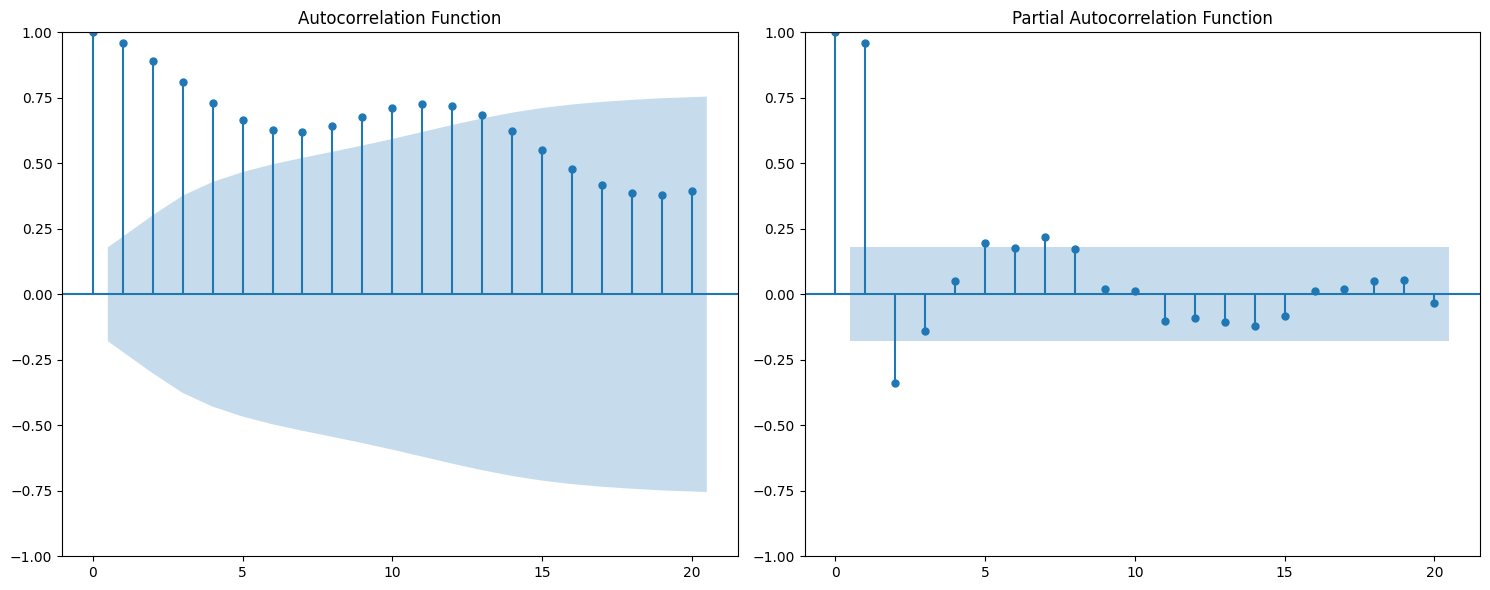

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 计算ACF和PACF
lag_acf = acf(data, nlags=20)
lag_pacf = pacf(data, nlags=20, method='ols')

# 绘制ACF图
plt.figure(figsize=(15, 6))
plt.subplot(121)
plot_acf(data, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

# 绘制PACF图
plt.subplot(122)
plot_pacf(data, ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

### 频域分析
对数据进行傅里叶变换，分析其频域特性。这可以帮助识别数据中的主要频率，从而揭示隐藏的周期性。

通过对时间序列数据进行傅里叶变换，我们获得了频域的表示。在生成的频域图中，X轴表示频率，Y轴表示每个频率对应的幅度。

从这张图表中，我们可以观察到以下几点：

- 主要频率：幅度较大的峰值对应的频率代表了数据中的主要周期。在这个例子中，如果有一个显著的峰值，那么它可能对应于数据中的主要周期性成分。例如，如果12个单位的频率处有一个峰值，这可能代表一个每12个时间单位重复一次的周期，与年度季节性相对应。
- 幅度：峰值的幅度表示该频率成分在数据中的强度。更高的幅度意味着该频率的周期性成分更为显著。
- 噪声：除了主要的周期性峰值之外，其他小的幅度波动可能代表噪声或不那么显著的周期性成分。



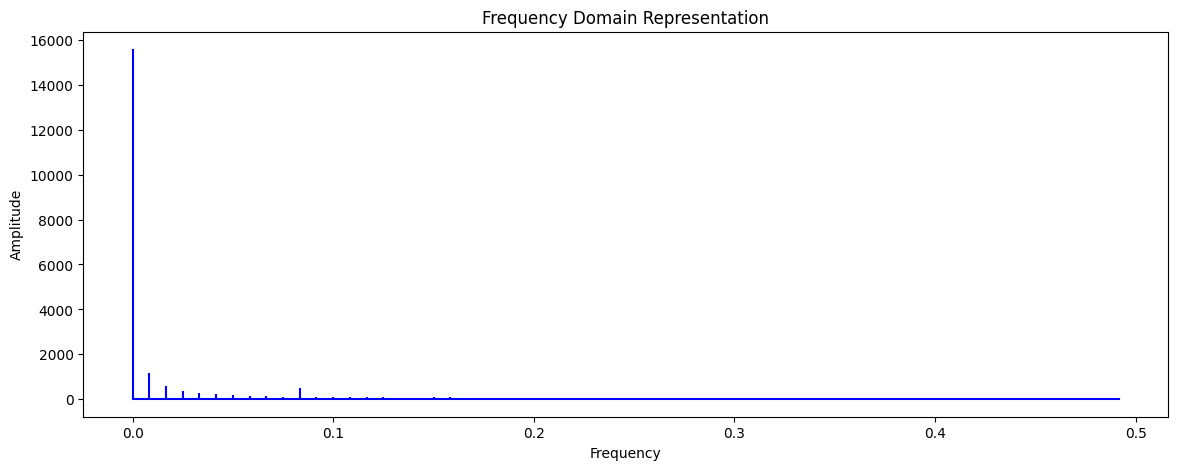

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据，之前例子中用于产生时间序列的参数
np.random.seed(0)
data_length = 120
time = np.arange(data_length)
data = 100 + 0.5 * time + 10 * np.sin(2 * np.pi * time / 12) + np.random.normal(size=data_length)

# 傅里叶变换
fft_result = np.fft.fft(data)
fft_freq = np.fft.fftfreq(data_length, d=1)  # 使用默认的时间步长1个单位

# 因为FFT结果是对称的，我们只关心正频率部分
positive_freqs = fft_freq[:data_length // 2]
positive_fft = np.abs(fft_result)[:data_length // 2]

# 创建一个用于展示结果的图表
plt.figure(figsize=(14, 5))

# 绘制频率和幅度
plt.stem(positive_freqs, positive_fft, 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain Representation')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()



In [4]:
# 假设 fft_result 是傅里叶变换的结果，positive_frequencies 是对应的频率数组
max_amplitude_index = np.argmax(np.abs(fft_result))
main_frequency = positive_freqs[max_amplitude_index]
# 计算周期
main_period = 1 / main_frequency

# 假设 fft_result 是傅里叶变换的结果，positive_frequencies 是对应的频率数组
# 转换为振幅并忽略第一个元素，因为它通常代表直流分量（趋势）
frequencies = positive_freqs[1:]

# 找到次要峰值的索引
# np.argsort 会返回从小到大的索引值，我们取最后几个索引以得到最大的振幅值
sorted_indices = np.argsort(positive_fft)
secondary_peak_index = sorted_indices[-2]  # 假定次高的峰值是我们感兴趣的

# 对应的次要频率
secondary_frequency = frequencies[secondary_peak_index]

# 计算周期
secondary_period = 1 / secondary_frequency
print("主要频率：", main_frequency, "周期：", main_period)
print("次要频率：", secondary_frequency, "周期：", secondary_period)

主要频率： 0.0 周期： inf
次要频率： 0.016666666666666666 周期： 60.0


C:\Users\FUDIAN\AppData\Local\Temp\ipykernel_29584\2594277143.py:5: RuntimeWarning:

divide by zero encountered in scalar divide



# DataSource类

In [11]:
import pandas as pd
import sqlite3
import re
from asteval import Interpreter

class DataManager:
    SQLITE_DB_PATH = 'data/futures.db'  # 定义SQLite数据库的常量路径
    def __init__(self):
        self.sources = {}
        self.cache = {}

    def add_data_source(self, variety, data_name, data_config):
        """
        向数据源列表中添加一个新的数据源。
        """
        # 在self.sources字典中添加新的数据源信息
        data_config['Variety'] = variety
        self.sources[data_name] = data_config


    def get_data(self, name):
        """
        根据提供的名称从数据源获取数据，并进行必要的转换。
        
        参数:
        - name: 数据源的名称，用于标识需要获取数据的来源。
        
        返回值:
        - 返回从指定数据源加载并转换后的数据。
        
        抛出:
        - ValueError: 如果指定的数据源不存在。
        """
        # 检查缓存中是否已有数据，如果有则直接返回
        if name in self.cache:
            return self.cache[name]

        # 如果数据源不存在于 sources 中，抛出 ValueError
        if name not in self.sources:
            raise ValueError("Data source not found")

        # 获取数据源信息，并确保 'date' 列存在于数据列中
        source = self.sources[name]
        columns = source['Field']
        formula = None
        if isinstance(columns, str):  # 如果是字符串公式，解析出涉及的列名
            formula = columns              
            columns = self._parse_columns_from_formula(columns)           
        source['Field'] = columns if 'date' in columns else ['date'] + columns

        # 从数据源加载数据
        data = self._load_data(source)
        
        # 如果有转换函数，对数据进行转换
        if 'Transform' in source:
            data = self._transform_data(data, source['Transform'], columns)
        # 如果原始列定义是公式
        if formula and len(columns)>1:  
            data = self._calculate_formula(data, name, formula, columns)
        # 将处理后的数据缓存起来
        self.cache[name] = data

        return data

    def _load_data(self, source):
        """
        根据提供的数据源信息从SQLite数据库/ChoiceExcel文件中加载数据。
        """
        if source['Source'] == 'SQLite':
            return self._load_data_from_sqlite(source['Variety'],source['Path'],  source['Field'])
        elif source['Source'] == 'Choice':
            return self._load_data_from_excel(source['Path'], source['Field'])
        elif source['Source'] == 'Calculate':
            return None
        else:
            raise ValueError(f"Unsupported data source type: {source['Source']}")

    def _load_data_from_sqlite(self, variety, path, field):
        """
        从SQLite数据库中加载数据。
        """
        conn = sqlite3.connect(self.SQLITE_DB_PATH)
        query = f"SELECT {', '.join(field)} FROM {path}"
        if variety:
            query += f" WHERE variety = '{variety}'"
        data = pd.read_sql_query(query, conn)
        conn.close()
        return data

    def _load_data_from_excel(self, path, field):
        """
        从ChoiceExcel文件中加载数据。
        """
        if not path:
            return None
        # 读取Excel文件，跳过前1行（假设第一行是“宏观数据”等标题，不是列名称）
        df = pd.read_excel(path, header=1)  # 利用header=1使得第2行（即索引1）作为列标题
        # 数据有效行从第7行开始，即需要跳过第2-6行（索引从0开始，所以是1-5）
        df = df[5:]  # 从第6行开始保留数据（因为header=1后，第二行已经变成了索引0）
        # 将第1列的名称改为'date'
        df.rename(columns={df.columns[0]: 'date'}, inplace=True)
        # 剔除日期列为空的行以及日期列为“数据来源：东方财富Choice数据”的行
        df = df[df['date'].notna() & (df['date'] != '数据来源：东方财富Choice数据')]
        # 将日期列转换为datetime类型
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        # 再次剔除转换错误后可能产生的NaT值
        df = df[df['date'].notna()]
        # 仅保留所需的列
        df = df[field]
        # for col in field:
        #     # 尝试将每一列转换为数值类型
        #     data[col] = pd.to_numeric(data[col])
        # 排除 datetime 类型的列，对其余列应用 pd.to_numeric
        df[df.select_dtypes(exclude=['datetime']).columns] = df.select_dtypes(exclude=['datetime']).apply(pd.to_numeric)        
        return df
    
    def _transform_data(self, data, how, on):
        """
        根据提供的转换函数对数据进行转换。
        
        参数:
        - data: 要转换的数据。
        - how: 转换函数的名称。
        - on: 要转换的列名。
        
        返回值:
        - 转换后的数据。
        """
        if how == 'Fill_Forward':
            data[on] = data[on].ffill().infer_objects()
        elif how == 'Fill_Backward':
            data[on] = data[on].bfill().infer_objects()
        return data

    def _parse_columns_from_formula(self, formula):
        """
        从公式中解析出涉及的列名。
        
        参数:
        - formula: 要解析的公式。
        
        返回值:
        - 提取出的列名列表。
        """
        # 这里需要一个解析器来从公式中提取列名
        # 示例实现，实际实现应更全面地处理字符串中的列名
        return re.findall(r'\w[\w:()%]*', formula)  # 假设列名是单词字符
    
    def _calculate_formula(self, data, name, formula, field):     
        """
        根据提供的公式对数据进行计算。
        
        参数:
        - data: 要计算数据的数据框。
        - name: 计算结果要保存的列名。
        - formula: 要计算的公式。
        - columns: 要计算公式的列名。
        
        返回值:
        - 计算后的数据。
        """              
        aeval = Interpreter() 
        for col in field:                    
            safe_col = re.sub(r'[0-9:]', '', col)
            data.rename(columns={col:safe_col}, inplace=True)
            aeval.symtable[safe_col] = data[safe_col]
        formula = re.sub(r'[0-9:]', '', formula)
        data[name] = aeval.eval(formula)
        return data


In [14]:
data_manager = DataManager()
import variety
rb = variety.SymbolData('RB')
rb.symbol_setting['DataIndex']
for name, data_config in rb.symbol_setting['DataIndex'].items():
    data_manager.add_data_source(rb.id, name, data_config)
    data_manager.get_data(name)

In [ ]:
# 创建 DataSourceManager 实例
data_manager = DataManager()

# 获取现货价格数据
# add_data_source的参数依次为：数据名称，数据源类型（包括：SQLite、ChoiceExcel、AKshare、YFinance，需要根据不同类型设计数据加载函数），数据加载函数的参数（数据库路径、表名称），需要返回的数据表的列名
data_manager.add_data_source('spot_price', 'SQLite', '', 'basis', variety='RB', columns=['spot_price'])
df = data_manager.get_data('spot_price')
print(df)

data_manager.add_data_source('inventory', 'ChoiceExcel', 'black_metals/data/铁矿石经济数据.xlsx', '',  '', ['库存:铁矿石:港口合计'], 'Fill_Forward')
df = data_manager.get_data('inventory')
print(df)

data_manager.add_data_source('inventory2', 'ChoiceExcel', 'black_metals/data/螺纹钢经济数据.xlsx', '',  '', "137家螺纹钢厂:社会库存 + 137家螺纹钢厂:钢厂库存", 'Fill_Forward')
df = data_manager.get_data('inventory2')
print(df)

# Variety类

In [1]:
import time
import cProfile
import pstats
import modules.variety as variety
import modules.indicator as indicator

# profiler = cProfile.Profile()
# profiler.enable()

rb = variety.Variety('RB')
rb.load_data()

# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('cumtime')
# stats.print_stats(r'e:\\Document\\Project\\futures_nexus\\')


In [3]:
# 重新加载salary计算模块
import importlib
importlib.reload(variety)
importlib.reload(chart)
importlib.reload(indicator)

<module 'modules.indicator' from 'e:\\Document\\Project\\futures_nexus\\modules\\indicator.py'>

In [4]:
import modules.chart as chart
profiler = cProfile.Profile()
profiler.enable()

chart_manager = chart.ChartManager(rb)
chart_manager.load_indicators()
chart_manager.calculate_indicators()
chart_manager.plot()
chart_manager.update_figure()
chart_manager.main_figure.show()

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats(r'e:\\Document\\Project\\futures_nexus\\')
profiler.clear()

         2121972 function calls (1957324 primitive calls) in 1.290 seconds

   Ordered by: cumulative time
   List reduced from 1240 to 22 due to restriction <'e:\\\\Document\\\\Project\\\\futures_nexus\\\\'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.775    0.775 e:\Document\Project\futures_nexus\modules\chart.py:42(plot)
       11    0.000    0.000    0.499    0.045 e:\Document\Project\futures_nexus\modules\chart.py:43(_add_trace)
        1    0.000    0.000    0.283    0.283 e:\Document\Project\futures_nexus\modules\chart.py:94(update_figure)
        8    0.000    0.000    0.191    0.024 e:\Document\Project\futures_nexus\modules\indicator.py:144(figure)
        1    0.000    0.000    0.114    0.114 e:\Document\Project\futures_nexus\modules\chart.py:79(_create_main_figure)
        1    0.000    0.000    0.084    0.084 e:\Document\Project\futures_nexus\modules\chart.py:38(calculate_indicators)
        2    0.000    0.000  

In [ ]:
chart_manager = chart.ChartManager(rb)
config = rb.symbol_setting['DataIndex']
close = indicator.SimpleIndicator('收盘价', rb, config['收盘价'])
spread = indicator.SimpleIndicator('跨月价差', rb, config['跨月价差'])
receipt = indicator.RankColorIndicator('库存', rb, config['库存'])
chart_manager.add_indicator('收盘价', close)
chart_manager.add_indicator('跨月价差', spread)
chart_manager.add_indicator('库存', receipt)
chart_manager.calculate_indicators()
chart_manager.plot()
chart_manager.main_figure.update_xaxes(
    showgrid=False,
    zeroline=True,
    dtick="M1",  # 按月显示
    ticklabelmode="period",   # instant  period
    tickformat="%m\n%Y",
    rangebreaks=[dict(values=rb.get_trade_breaks())],
    rangeslider_visible = False, # 下方滑动条缩放
)